In [1]:
import pickle

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns

In [2]:
import sys
sys.path.insert(0, "../../")
from utils import directed_er_generator, team_maker, motif_adder, degree_maker, alpha_generator, khot

# Overview

We create a directed graph where the teams' label is driven by the value of the **in-degree** of the team respect to other teams. 

The graph is initially built defining the desired number of nodes (teams' members) inside the network. After that, we assign each node in the network to a single team. At the end of this step, we create an internal structure (adding edges between nodes of the same team) for each team using an unique motif structure.

Finally, we add new edges into the network in order to discriminate the teams based on in-degreee. The first step is to keep `n_classes` normal distributions with different centers (distances between these centers is determined by `separation`) and we split the teams into `n_classes` groups more possible equally distributed. Each team receives new edges from the outside (no same team) based on the corresponding normal distribution. The nodes of the team that receive these edges is determined by the functions (`khot`, `arithmetic`, etc.). For example, the `khot` method works connecting the new edges to k nodes of the team.

In [3]:
# Create random directed graph.
G = directed_er_generator(n = 10000)

In [4]:
# Remove self-loop.
G.remove_edges_from(nx.selfloop_edges(G))

In [5]:
# Assign each node to a team.
G, teams_composition = team_maker(G)

In [6]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of teams: {len(teams_composition)}")

Number of nodes: 10008
Number of teams: 990


In [7]:
# Add unique motif structure to each team.
G, _ = motif_adder(G, teams_composition, motifs = [1])

In [8]:
# Assign to each team a class based on the in-degree distribution.
G, teams_label, _ = degree_maker(G, teams_composition, n_classes = 3, separation = 20, method = "khot", degree = "in", bl = 10, k = 1)

In [9]:
df = pd.DataFrame(teams_composition.items(), columns = ["team", "members"])
df["label"] = df["team"].map(teams_label)
df.head()

,team,members,label
0,0,"[9065, 836, 3726, 4500, 8681, 6220, 377, 651, ...",1
1,1,"[6047, 610, 9150, 8119, 4726, 7978, 8563, 7699...",0
2,2,"[3558, 8074, 3740, 9298, 4902, 1022, 378, 8853...",0
3,3,"[540, 5354, 158, 8206, 9029, 9108, 8888, 6219,...",1
4,4,"[821, 6590, 406, 8427, 9801, 5498, 7261, 5795]",1


In [10]:
# Create team composition dictionary: {node_id: [team_id]}.
teams_composition = df.explode("members").groupby("members").apply(lambda x: list(x["team"])).to_dict()

In [11]:
# Add team attribute to each node.
nx.set_node_attributes(G, teams_composition, "Team") 

In [12]:
# Save networkx graph.
with open(f"./data/graph.pkl", "wb") as f:
    pickle.dump(nx.readwrite.json_graph.node_link_data(G), f)
    
# Save teams label.
with open(f"./data/teams_label.pkl", "wb") as out:
    pickle.dump(teams_label, out)

# Visualization

Let's reproduce the previous graph in a smaller scale.

In [13]:
# Create random directed graph.
G = directed_er_generator(n = 40)
G.remove_edges_from(nx.selfloop_edges(G))
# Assign each node to a team.
G, teams_composition = team_maker(G)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of teams: {len(teams_composition)}")

# Add unique motif structure to each team.
G, _ = motif_adder(G, teams_composition, motifs = [1])

# Assign to each team a class based on the in-degree distribution.
G, teams_label, discriminative_nodes = degree_maker(G, teams_composition, n_classes = 3, separation = 5, method = "khot", degree = "in", bl = 10, k = 1)

Number of nodes: 40
Number of teams: 4


In [14]:
df = pd.DataFrame(teams_composition.items(), columns = ["team", "members"])
df["label"] = df["team"].map(teams_label)
df = df.explode("members").sort_values("members", ignore_index = True)
df.head()

,team,members,label
0,3,0,0
1,3,1,0
2,0,2,2
3,3,3,0
4,0,4,2


In [15]:
node_teams = df.set_index("members")["team"].to_dict()
node_labels = df.set_index("members")["label"].to_dict()
node_colors = [sns.color_palette("pastel")[label] for label in df["team"].tolist()]

In [16]:
# Add team attribute to each node.
nx.set_node_attributes(G, node_teams, "Team") 
nx.set_node_attributes(G, node_labels, "Label") 

In [17]:
# Let's compute graph position in order to set nodes belonging to the same team near among themself.
teams = df["team"].sort_values().unique()

graphs = df.groupby("team")["members"].apply(nx.complete_graph).tolist()
edges = [(np.random.choice(graphs[i-1].nodes), np.random.choice(graphs[i].nodes)) for i in range(len(graphs))]
graph = nx.compose_all(graphs)
graph.add_edges_from(edges)

pos = nx.layout.kamada_kawai_layout(graph)

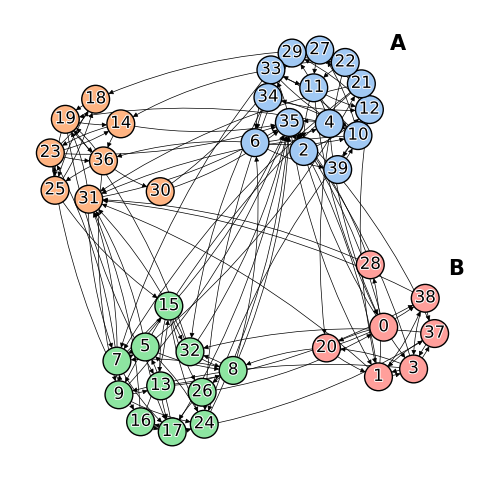

In [18]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.axis("off")

nx.draw_networkx_edges(G, pos, width = 0.5, arrowsize = 7, node_size = 400, connectionstyle = "arc3, rad = 0.1", ax = ax)
nodes = nx.draw_networkx_nodes(G, pos, node_color = node_colors, linewidths = 1., node_size = 400, ax = ax)
ax.collections[0].set_edgecolor("k") 

# Node names.
for node, (x, y) in pos.items():
    ax.text(x, y-0.02, node, c = "k", ha = "center", size = 12, 
            path_effects = [pe.withStroke(linewidth = 1.4, foreground = "w")])   
# Team names.   
team_names = {r"$\bf{A}$": (0.8, 0.9), r"$\bf{B}$": (1.1, -0.2)}
for m, (x, y) in team_names.items():
    ax.text(x, y-0.02, m, ha = "center", size = 15)   
    
fig.savefig("./data/centrality.png", bbox_inches = "tight", dpi = 300)

In [19]:
discriminative_nodes

[{7}, {0}, {31}, {35}]

In [20]:
target_node = 35
target_team = node_teams[target_node]

edges = []
for e in G.edges():
    if e[1] == target_node and e[0] in df.query("team != @target_team")["members"].tolist():
        edges.append(e)

C:\Users\Pietro\AppData\Local\Temp\ipykernel_16860\2774178586.py:4: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist = G.edges(), width = 0.5, arrowsize = 7, node_size = 400, connectionstyle = "arc3, rad = 0.1",


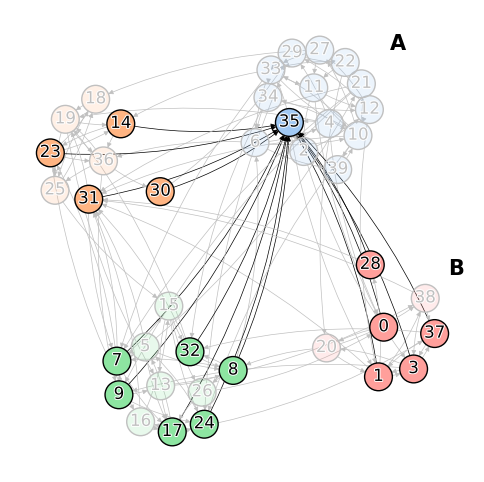

In [21]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.axis("off")

nx.draw_networkx_edges(G, pos, edgelist = G.edges(), width = 0.5, arrowsize = 7, node_size = 400, connectionstyle = "arc3, rad = 0.1", 
                       edge_color = ["k" if e in edges else "#C0C0C0" for e in G.edges()], ax = ax)
nodes = nx.draw_networkx_nodes(G, pos, linewidths = 1., node_size = 400, ax = ax, 
                               node_color = [c if i in set(sum(edges, ())) else (c[0], c[1], c[2], 0.2) for i, c in enumerate(node_colors)])
nodes.set_edgecolor(["k" if i in set(sum(edges, ())) else "#C0C0C0" for i, c in enumerate(node_colors)]) # node border

# Node names.
for node, (x, y) in pos.items():
    ax.text(x, y-0.02, node, c = "k" if node in set(sum(edges, ())) else "#C0C0C0", ha = "center", size = 12, 
            path_effects = [pe.withStroke(linewidth = 1.4, foreground = "w")]) 
# Team names.   
team_names = {r"$\bf{A}$": (0.8, 0.9), r"$\bf{B}$": (1.1, -0.2)}
for m, (x, y) in team_names.items():
    ax.text(x, y-0.02, m, ha = "center", size = 15)  
    
fig.savefig("./data/centrality_1.png", bbox_inches = "tight", dpi = 300)

In [22]:
target_node = 0
target_team = node_teams[target_node]

edges = []
for e in G.edges():
    if e[1] == target_node and e[0] in df.query("team != @target_team")["members"].tolist():
        edges.append(e)

C:\Users\Pietro\AppData\Local\Temp\ipykernel_16860\1378109137.py:4: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist = G.edges(), width = 0.5, arrowsize = 7, node_size = 400, connectionstyle = "arc3, rad = 0.1",


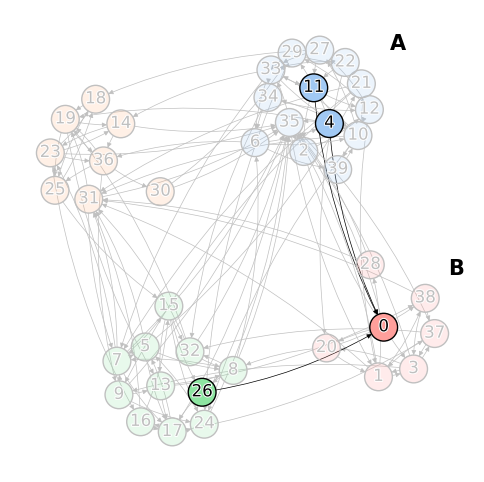

In [23]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.axis("off")

nx.draw_networkx_edges(G, pos, edgelist = G.edges(), width = 0.5, arrowsize = 7, node_size = 400, connectionstyle = "arc3, rad = 0.1", 
                       edge_color = ["k" if e in edges else "#C0C0C0" for e in G.edges()], ax = ax)
nodes = nx.draw_networkx_nodes(G, pos, linewidths = 1., node_size = 400, ax = ax, 
                               node_color = [c if i in set(sum(edges, ())) else (c[0], c[1], c[2], 0.2) for i, c in enumerate(node_colors)])
nodes.set_edgecolor(["k" if i in set(sum(edges, ())) else "#C0C0C0" for i, c in enumerate(node_colors)]) # node border

# Node names.
for node, (x, y) in pos.items():
    ax.text(x, y-0.02, node, c = "k" if node in set(sum(edges, ())) else "#C0C0C0", ha = "center", size = 12, 
            path_effects = [pe.withStroke(linewidth = 1.4, foreground = "w")]) 
# Team names.   
team_names = {r"$\bf{A}$": (0.8, 0.9), r"$\bf{B}$": (1.1, -0.2)}
for m, (x, y) in team_names.items():
    ax.text(x, y-0.02, m, ha = "center", size = 15)  
    
fig.savefig("./data/centrality_2.png", bbox_inches = "tight", dpi = 300)